---
title: Predicting alternative polyadenylation with Borzoi
date: 2025-05-05
author: Sofia Salazar
categories:
    - notebook
    - gene46100
---

## Predicting alternative polyadenylation with Borzoi

### Overview

[Borzoi](https://www.nature.com/articles/s41588-024-02053-6) is a deep learning model that, similarily to Enformer: 

- Takes DNA sequences as input (one-hot encoded) 

- Uses a convolutional neural network architecture and transformer layers 

- Predicts multiple genomic features simultaneously

However, Borzoi was rained to predict RNA-seq coverage as well, which makes it useful for the following aplication: predicting 3'UTR alternative polyadenylation (APA).

3'UTR APA is a post-transcriptional regulatory mechanism that allows transcripts from a gene to have different lengths due to differential polyA signal usage leading to different lengths of 3'UTR regions. Variants on the 3'UTR sequence that alter the length of the region are refered to 3'aQTLs [read more here](https://www.nature.com/articles/s41588-021-00864-5).

### Objective

In this notebook we will learn how to use borzoi to predict RNA-seq coverage around one 3'aQTL by predicting on both the reference and the alternative sequence. We will plot the differences on RNA-seq prediction at the 3'UTR for the whole blood borzoi tracks.

## 1. Set up a borzoi-adequate environment

The requirements for running borzoi are outlined [here](https://github.com/calico/borzoi/). The most important dependencies are **python ==3.10** and **tensorflow==2.15.x**.

I had to install python 3.10 and found that working with a `venv` worked as of may 5th 2025.

I followed the instructions to use the GPU of my macbook [here](https://developer.apple.com/metal/tensorflow-plugin/)

```{bash}
brew install python@3.10
python3.10 -m venv ~/borzoiTools
source ~/borzoiTools/bin/activate
python -m pip install -U pip
python -m pip install ipykernel
python3 -m ipykernel install --user --name=borzoiTools
python3 -m pip install tensorflow==2.15
python3 -m pip install tensorflow-metal
```

To verify python and tensforflow versions, run the following chunks:

In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        print("TensorFlow is using the GPU.")
    except RuntimeError as e:
        print(e)
else:
    print("TensorFlow is not using the GPU. Check your TensorFlow installation.")


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow is using the GPU.


In [4]:
import sys
print(sys.version)

3.10.17 (main, Apr  8 2025, 12:10:59) [Clang 16.0.0 (clang-1600.0.26.6)]


In [5]:
print(tf.__version__)

2.15.0


## 2. Install borzoi and dependencies

Borzoi depends on the baskerville software, run the following chunks to install both on your environment:

In [6]:
%cd /Users/sofiasalazar/Desktop/IM_lab/borzoi_folder

/Users/sofiasalazar/Desktop/IM_lab/borzoi_folder


/Users/sofiasalazar/borzoiTools/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
!git clone https://github.com/calico/baskerville.git

In [ ]:
%cd baskerville
%pip install -e .

In [ ]:
%cd ..
!git clone https://github.com/calico/borzoi.git

In [ ]:
%cd borzoi
%pip install -e .

Then I installed other libraries that we will be using as well

In [ ]:
%pip install kipoiseq
%pip install h5py

**Here I had to restart the kernel to use baskerville**

## 3. Download models

The borzoi models are each ~1GB (~4GB in total as there are 4 models, each correspond to a cross validation fold from the training process). Further down you'll see that we can choose to predict using the 4 models or only a couple of them.

In [ ]:
%cd /Users/sofiasalazar/Desktop/IM_lab/borzoi_folder/borzoi
! ./download_models.sh 

## 4. Set up borzoi and helper functions

The previous steps are run only once, afterwards, we can set up the borzoi functions as well as other utilities to extract the reference sequence and mutate it.

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import baskerville
from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna
import json
import kipoiseq
import pyfaidx

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
DEVICE = "/GPU:0"

Change the following paths to your personal paths

In [8]:
BORZOI_PATH = "/Users/sofiasalazar/Desktop/IM_lab/borzoi_folder/borzoi"
models_path = os.path.join(BORZOI_PATH, "examples/saved_models" )
fasta_file = "/Users/sofiasalazar/Library/CloudStorage/Box-Box/imlab-data/Reference-Data/ref_sequences/hg38/Homo_sapiens_assembly38.fasta"
params_file = os.path.join(BORZOI_PATH, "examples/params_pred.json")
targets_file = os.path.join(BORZOI_PATH, "examples/targets_human.txt")

The following classes will help us extract the reference genome sequence, mutate it and one hot encode it.

In [20]:
class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}
    #import pd.Interval as Interval
    def extract(self, interval: kipoiseq.Interval, snp_position = None, snp_base=None, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = kipoiseq.Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        
        # Apply SNP modification if specified
        if snp_position and snp_base:
            pos = snp_position - trimmed_interval.start - 1
            if 0 <= pos < len(sequence):
                print(sequence[pos-1:pos+2])
                sequence = sequence[:pos] + snp_base + sequence[pos + 1:]
                print(sequence[pos-1:pos+2])
                
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()
    
def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


Borzoi prediction functions

**Here we define how many model folds we want to use for the prediction**

In [10]:
n_reps = 1

In [11]:
seq_len = 524288
rc = True         #Average across reverse-complement prediction

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

params_model['trunk'][-2]['cropping'] = 0


targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index 

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

models = []
for rep_ix in range(n_reps) :
    model_file = os.path.join(BORZOI_PATH, f"examples/saved_models/f3c{rep_ix}/train/model0_best.h5")
    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, [0])
    
    models.append(seqnn_model)

def predict_tracks(models, sequence_one_hot):

    predicted_tracks = []
    for fold_ix in range(len(models)):

        yh = models[fold_ix](sequence_one_hot[None, ...])[:, None, ...].astype(
            "float16"
        )

        predicted_tracks.append(yh)

    predicted_tracks = np.concatenate(predicted_tracks, axis=1)

    return predicted_tracks

def make_prediction(sequence):
    with tf.device(DEVICE):
        y_wt = predict_tracks(models, sequence)
        return y_wt

2025-05-05 13:09:41.154901: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-05 13:09:41.154939: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-05 13:09:41.154952: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-05 13:09:41.155004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-05 13:09:41.155040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 5. Predict for a 3'aQTL

In [this paper](https://www.nature.com/articles/s41588-021-00864-5), 3' alternative polyadenylation QTLs (1'aQTLs) where identified using gtex individuals. They were stored [here](https://doi.org/10.7303/syn22236281). 

For the purpose of this example, we will focus on the variant **rs10954213**: chr7_128949373_G_A (hg38), which is one of the whole blood 3'aQTLs that was reported on the paper (Figure 1b)

In [21]:
fasta_extractor = FastaStringExtractor(fasta_file)

In [13]:
sequence_interval = kipoiseq.Interval("chr7", 128949373, 128949374)

In [22]:
reference_one_hot = one_hot_encode(fasta_extractor.extract(sequence_interval.resize(seq_len)))

Here the `snp_position` argument of the `extract` function refers to the position in the sequence where we want to introduce the mutation. `snp_base` is the nucleotide which will replace the reference nucleotide.

Note that in the output, the reference and mutated nucleotides are printed in the middle of the upstream and downstream nucleotides.

In [23]:
mutated_one_hot = one_hot_encode(fasta_extractor.extract(sequence_interval.resize(seq_len), snp_position=128949373, snp_base='A'))

TGA
TAA


In [24]:
reference_one_hot = reference_one_hot.astype("float32")
mutated_one_hot = mutated_one_hot.astype("float32")

In [29]:
pred_reference = make_prediction(reference_one_hot)

In [30]:
pred_reference.shape

(1, 1, 16384, 7611)

We remove the 0 dimension and average across the 1 dimension (folds)

In [31]:
pred_reference = pred_reference.squeeze(0).mean(axis = 0)
pred_reference.shape

(16384, 7611)

Then we keep only the whole blood RNA-seq prediction [see track description here](https://github.com/calico/borzoi/blob/main/examples/targets_human.txt)

In [32]:
pred_reference = pred_reference[:, 7531:7534]
pred_reference.shape

(16384, 3)

Average across the RNA blood tracks

In [ ]:
pred_reference = pred_reference.mean(axis = 1 )

In [34]:
pred_reference.shape

(16384,)

We do the same for the mutated sequence

In [35]:
pred_mutated = make_prediction(mutated_one_hot)
pred_mutated = pred_mutated.squeeze(0).mean(axis = 0)
pred_mutated = pred_mutated[:, 7531:7534]
pred_mutated = pred_mutated.mean(axis = 1 )

In [36]:
pred_mutated.shape

(16384,)

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def plot_tracks_nested(nested_tracks, interval, highlight_position = None, alpha = 0.4, height=1.5):
    """
    nested_tracks: dict of dicts
        Outer keys: data sources (e.g., replicates or conditions)
        Inner keys: track names to plot (these become the rows)
    interval: a kipoiseq interval with .start and .end
    """
    all_inner_keys = set()
    for subdict in nested_tracks.values():
        all_inner_keys.update(subdict.keys())
    all_inner_keys = sorted(all_inner_keys)

    n_tracks = len(all_inner_keys)
    fig, axes = plt.subplots(n_tracks, 1, figsize=(20, height * n_tracks), sharex=True)

    if n_tracks == 1:
        axes = [axes]

    for ax, inner_key in zip(axes, all_inner_keys):
        for outer_key, subdict in nested_tracks.items():
            if inner_key in subdict:
                y = subdict[inner_key]
                x = np.linspace(interval.start, interval.end, num=len(y))
                ax.fill_between(x, y, alpha=alpha, label=outer_key)
        ax.set_title(inner_key, fontsize=11)
        ax.legend(loc='upper right', fontsize=8, frameon=False)
        sns.despine(ax=ax, top=True, right=True, bottom=True)
        if highlight_position is not None and interval.start <= highlight_position <= interval.end:
            ax.axvline(x=highlight_position, color='black', linestyle='--', linewidth=1)

    axes[-1].set_xlabel(str(interval))
    plt.tight_layout()
    plt.show()

Since we are only interested in the 3'UTR region, we will center our plot on the 64 middle bins (for borzoi, each bin is 32 base pair-long). Remember that the prediction is centered at the 3'aQTL (dashed line on the plot). Indeed the coverage difference between the reference and alternative sequences is evident.

In [45]:
pred_reference[8160:8224, ].shape

(64,)

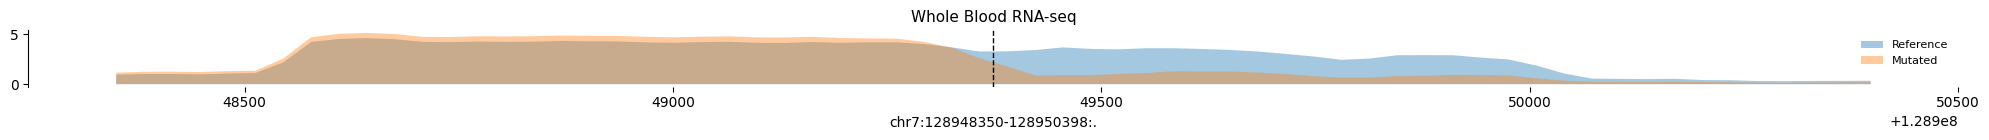

In [50]:
tracks = {'Reference': {'Whole Blood RNA-seq': pred_reference[8160:8224, ]},
          'Mutated': {'Whole Blood RNA-seq': pred_mutated[8160:8224, ]}}
plot_tracks_nested(tracks, sequence_interval.resize(64*32), highlight_position=sequence_interval.start)